# Добро Пожаловать!
---

Сегодня мы займемся полным процессом обработки базы данных, причем взятой из реальной жизни, на основе которых можно даже показать некие результаты **о жизни людей!**
## <br><br><br>Тематика 
В основе сегодняшнего занятия будет лежать полный анализ в линейной регрессии, однако нужно также не упускать возможность рассмотреть, а главное полностью прокомментировать каждый шаг, самостоятельно написать его своими ручками (даже теор данные!). Поэтому многие этапы будут для меня впервые, и возможно я что-то буду понимать не так, как есть.
## <br><br><br>Смысл
Как оказалось, хоть я и прошел линейную регрессию, я не особо понимаю фундаментальный смысл происходящего - на основе чего построены формулы, библиотеки, и тд. *Да* настоящему программисту нужно ооочень много изучать и готовых решений, однако они построены на серьезном математическом аппарате, не знать который - грех
## <br><br><br>Датасет
Давайте для начала я покажу вам базу данных, которую я буду использовать, и расскажу, чем я буду заниматься.
Мы будем строить линейную регрессию для данных о медицинских расходах людей различных параметров, имеющих разные привычки, вес, возраст, место проживания, и тд.
У нас есть данные, сколько тратилось денег на разных людей, и наша задача теперь - составить программу, которая сможет сама определять для мед страховки, сколько денег вам нужно выделить из бюджета.
Но перед там, как начинать что-то делать, давайте изучим теорию! Ведь как однажды сказать мой старый дед: 
> "Перед тем как познать истинное наслаждение, нужно немного помучаться".

Писать долгое определение того, что такое Линейная Регрессия, не стану, ведь для этого существует <a href="https://ru.wikipedia.org/wiki/Линейная_регрессия"> *Википедия* </a>

---
## <br>Линейная регрессия (*опять?*)
Мысль состоит в том, что у каждого параметра, который мы хотим изучить в реальности, есть определенные коэффициенты, который в опр степени будут менять этот параметр.
Давайте с примера: Ваша будущая зарплата будет увеличиваться прямо пропорционально вашему опыту. То есть можно придумать такую зависимость между двумя параметрами: <br>
$$\mathbf{ y=w_{1} \cdot x_{1}  }$$ где  $ x_{1} $ - функция вашего опыта в работе, $ y $ - Ваша зарплата, а $ w_{1}  $ - коэффициент зависимости между этими двумя параметрами. Также вводятся такие обозначения: y - зависимая переменная, x - независимая переменная
На самом деле, размер вашей зарплаты выглядит, конечно, не так просто, потому что у него не только один коэффициент, а много других параметров: <br>
$$ \hat{y}_i=w_{1 i} \cdot x_{1 i} + w_{2 i} \cdot x_{2 i} + w_{3 i} \cdot x_{3 i} + <...> + b $$ где b - Свободных параметр, i- номер точки являющимся решением <br>
Если что, обозначение $\hat{y}_i$ обозначает не просто параметр, а именно машинный параметр, найденный нами. Это важно знать!
Такая формула записи называется также  **Множественной линейной регрессией** , ей мы сегодня, может, тоже займемся.
Для удобства часто также избавляются от свободного параметра b, потому что нам придется перейти в матричных вид записи. Поэтому говорят, что есть еще один параметр, который называют *единичным*, т.е. <br> $$ b = b \cdot 1 = b \cdot x_{0}$$
Также стоит упомянуть и фактор ошибки, но о нем пока рано говорить)
Для начала давайте импортнем несколько библиотек, а также настроим параметры матплота

In [1]:
import pandas as pd # Манипулирует данными
import numpy as np # Манипулирует данными
import matplotlib.pyplot as plt # Визуализирует данные
import seaborn as sns # Визуализация данных в виде ступеньчатых данных и тд
plt.rcParams['figure.figsize'] = [8,5]
plt.style.use('seaborn-v0_8')

Теперь давайте подключим уже наконец датасет, здесь 7 столбцов, 1338 строк, поэтому данных уже прилично для моего опыта, но это наоборот круто!

In [2]:
df=pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Теперь подробнее о данных - здесь расписаны такие вещи, как возраст (age), пол (sex), Индекс массы тела (bmi), кол-во детей (children), Курит ли человек (smoker, 1 =yes, 2 =no), регион проживания по стране (какая это страна - умалчивается). Наша, собственно, задача - <br>
## *спрогнозировать индивидуальные медицинские расходы, которые будут оплачиваться медициской страховкой*
Как и говорилось ранее, у нас 1338 строк (то есть 1338 примеров для тренировки), и 7 различных параметров (т.е. независимых переменных), поэтому мы сначала должны составить матрицу из 1338 строк, в которой будут такие параметры:
$$\mathbf{ h_\theta(x_{i}) = \theta_0+\theta_1 возраст + \theta_2 пол + \theta_3 ИМТ + \theta_4 дети + \theta_5 курение + \theta_6 регион }$$
Это и будет уравнением множественной линейной регрессии, поздравляем! Осталось только найти все коэффициенты тетты для общего уравнения, и тогда всё получится! <br>
Если $\mathbf{i=1}$ тогда
$$\mathbf{h_\theta(x_{1}) = \theta_0+\theta_1 19 + \theta_2 female + \theta_3 27.900 + \theta_4 1 + \theta_5 yes + \theta_6 southwest}$$ 
$$\mathbf{y_1 = 16884.92400}$$
Если $\mathbf{i=3}$ тогда $$\mathbf{h_\theta(x_{3}) = \theta_0+\theta_1 28 + \theta_2 male + \theta_3 33.000 + \theta_4 3 + \theta_5 no + \theta_6 northwest}$$ 
$$\mathbf{y_3 = 4449.46200}$$
*Примечание: не стоит забывать, что индексы в питоне начинаются с нуля* <br>
## Тогда
матрица X будет состоять из строк такого типа:
$$\mathbf{x_1 = \left(\begin{matrix} x_{11} & x_{12} & x_{13} & x_{14} & x_{15} & x_{16}\end{matrix}\right) = \left(\begin{matrix} 19 & female & 27.900 & 1 & no & northwest\end{matrix}\right) }$$
А теперь, давайте окунемся еще немного в теорию, потому что без нее мы ничего не поймем

---
## Матричное представление
В общем случае мы можем записать нашу матрицу в размере m на n, содержащую все значения обучающих примеров:
$$\mathbf{X} = \left( \begin{smallmatrix} x_{11} & x_{12} &.&.&.&.& x_{1n}\\
                                x_{21} & x_{22} &.&.&.&.& x_{2n}\\
                                x_{31} & x_{32} &.&.&.&.& x_{3n}\\
                                .&.&.&. &.&.&.& \\
                                .&.&.&. &.&.&.& \\
                                x_{m1} & x_{m2} &.&.&.&.&. x_{mn}\\
                                \end{smallmatrix} \right)_{(m,n)}$$

Тогда можно и зависимую переменную y вместе с коэффициентами тетта представить в виде матриц:
$$\theta = \left (\begin{matrix} \theta_0 \\ \theta_1 \\ .\\.\\ \theta_j\\.\\.\\ \theta_n \end {matrix}\right)_{(n+1,1)} 
\mathbf{ y } = \left (\begin{matrix} y_1\\ y_2\\. \\. \\ y_i \\. \\. \\ y_m \end{matrix} \right)_{(m,1)}$$

Но почему мы тогда представили коэффициенты в виде столба, а не в виде строки, что логично? Ответ прост: Если я потом захочу перемножить матрицу $X$ на $ \theta $, для представления в аналитической форме, то нам нужен именно столбец, а не строка:
$$\mathbf{ h_\theta{(x)} = X\theta}$$
Теперь давайте рассмотрим зависимость расходов страховой фирмы от Индекса Массы Тела (в кг/м^2)

Text(0.5, 1.0, 'Зависимость Затрат от ИМП')

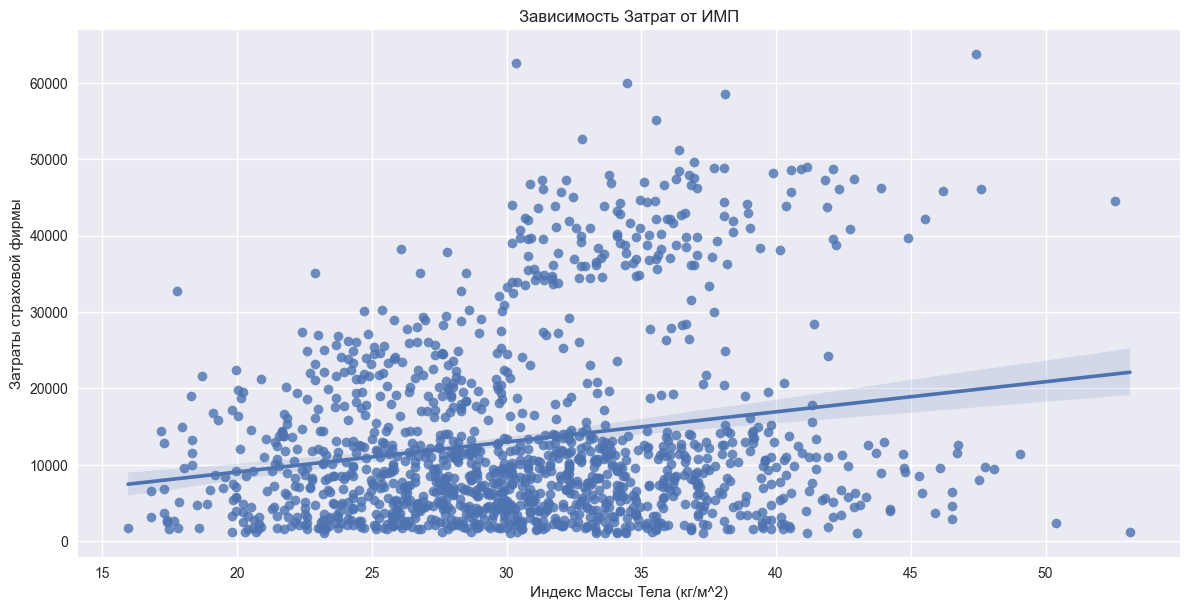

In [3]:
sns.lmplot(x='bmi',y='charges',data=df,aspect=2,height=6) # Быстрый способ построить график. У этой функции оч много возможностей
plt.xlabel('Индекс Массы Тела (кг/м^2)')
plt.ylabel('Затраты страховой фирмы')
plt.title('Зависимость Затрат от ИМП')

## Функция расходов
Для того, чтобы узнать, насколько точная наша *линейная* модель с точки зрения взаимосвязи между $X$ и $y$ , можно измерить нашу точность, используя так называемую ***фунцию расходов.***
Почитать подробнее можете по этой <a href="https://machinelearningknowledge.ai/cost-functions-in-machine-learning/" >*Cсылке*</a> (там есть прикольные анимации).
Для того, чтобы найти функцию расходов, нам потребуется сравнить среднее значение расходов (т.е. саму функцию линейной регрессии) с числом затрат $y$
$$\mathbf{ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}(\hat{y}_i - y_i)^2}$$
$$\mathbf{J(\theta) =  \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x_i) - y_i)^2}$$

Чтобы реализовать линейную регрессию, нам нужно для начала избавиться от начального свободного коэффициента. Для этого реализуем подход, описанный в самом начале этой темы, где мы вводим еще один независимый параметр $x_0$, где $\mathbf {x_0= 1}$. Так, входная матрица примет вид

$$\mathbf{X} = \left( \begin{smallmatrix} x_{10} & x_{11} & x_{12} &.&.&.&.& x_{1n}\\
                                x_{20} & x_{21} & x_{22} &.&.&.&.& x_{2n}\\
                                x_{30} & x_{31} & x_{32} &.&.&.&.& x_{3n}\\
                                 .&.&.&.&. &.&.&.& \\
                                 .&.&.&.&. &.&.&.& \\
                                x_{m0} & x_{m1} & x_{m2} &.&.&.&.&. x_{mn}\\
                                \end{smallmatrix} \right)_{(m,n+1)}$$  
То есть теперь мы заодно понимаем, что любой из $\mathbf{x_{10},x_{20},x_{30} .... x_{m0} =1}$. Теперь давайте перепишем наше уравнение в матричной форме.
Так, для того, чтобы переписать сумму квадратов разности, нужно вспомнить, что при перемножении транспонированной матрицы, на саму матрицу, мы получаем матрицу с квадратами значений. Получается в итоге такая матричая форма записи
$$\mathbf{J(\theta) = \frac{1}{m} (X\theta - y)^T(X\theta - y)}$$
Сделана замена свободного коэффициента не просто так. Проблема изначально заключалась в том, что перемножать матрица можно только в противоположными размерностями, а раньше не сходилось ровно на единицу. Именно поэтому решили ввести свободный коэффициент, и получилось! <br>

---
## Минимизация функции расходов
 Теперь нам (на самом деле мне) осталось решить аналитическую задачу на минимизацию полученной выше функции, меняя коэффициенты матрицы $\theta$. Я как найти минимум функции? Правильно! Найти производную, и приравнять к нулю, т.е:
 $$\mathbf{\frac{\partial J(\theta_j)}{\partial\theta_j} =0}$$ 
 где $\mathbf{j = 0,1,2,....n}$
 Решаем по действиям.
 + $\mathbf{\frac {1}{m}}$ убираем тк константа, после приравнивания к нулю уйдет (отвечаю)
 + Вспоминаем, что по свойству транспонирования, транспонирование разницы равно разницу транспонирований, такая же схема и с произведением, т.е:
 $$\mathbf{J(\theta) = (X\theta -y)^T(X\theta - y)}$$
 $$\mathbf{= (X\theta)^T - y^T)(X\theta -y)}$$   
 $$\mathbf{= (\theta^T X^T - y^T)(X\theta - y)}$$
 $$\mathbf{= \theta^T X^T X \theta - y^T X \theta - \theta^T X^T y + y^T y}$$
 $$\mathbf{ = \theta^T X^T X \theta  - 2\theta^T X^T y + y^T y}$$
Последняя строчка тоже по правилу (эхх, был у нас по квантовой механике препод Муравьев, мы с ним такими вещами часто занимались) : $\mathbf{ X^T y = y X }$
Тогда:
$$\mathbf{\frac{\partial J(\theta)}{\partial\theta} =  \frac{\partial}{\partial \theta} (\theta^T X^T X \theta  - 2\theta^T X^T y + y^T y)}$$ 
$$\mathbf{ = X^T X \frac {\partial \theta^T \theta}{\partial\theta} - 2 X^T y \frac{\partial \theta^T}{\partial\theta} + \frac {\partial y^T y}{\partial\theta}}$$
*Вспоминаем частные производные, в матрицах всё так же $\mathbf{\frac {\partial x^2}{\partial x} = 2x}$, $\mathbf{\frac {\partial kx^2}{\partial x} = kx}$,*
$\mathbf{\frac {\partial Const}{\partial x} = 0}$, ну и посление штрихи:
$$\mathbf{\frac{\partial J(\theta)}{\partial\theta} = X^T X 2\theta - 2X^T y +0}$$
$$\mathbf{ 0 = 2X^T X \theta - 2X^T y}$$
$$\mathbf{ X^T X \theta = X^T }$$
$$\mathbf{ \theta = (X^TX)^{-1} X^Ty }$$
Это и есть нормальное решение *Множественной линейной регрессии* (В последней строчке не путать Ноль и Тетту! Там стоит Тетта)
Так, с теорией пока что всё (только в мат части), теперь давайте рассмотрим матрицы корреляции, и вообще поймем, что это такое <br><br><br>
## Предварительный анализ данных
Для начала давайте посмотрим на граничные данные нашего списка данных, узнаем минимальные и максимальные значения каждого столбца данных:

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Для новеньких, std = стандартное отклонение, mean = среднее значение. <br>

---
## Просмотр пропущенных значений

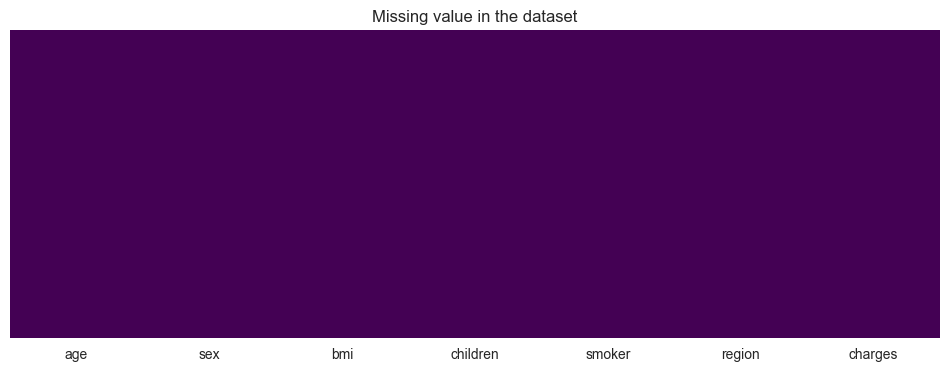

In [5]:
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False) #разобраться
plt.title('Missing value in the dataset');

Опа, тут появилась впервые для нас и тепловая карта, интересно. Подробнее можно узнать <a href="https://datastart.ru/blog/read/seaborn-heatmaps-13-sposobov-nastroit-vizualizaciyu-matricy-korrelyacii">ТУТ</a> <br>
Как видите, прощенных значений нигде нет, на предварительном анализе тоже проблем никаких не нашли (а мы искали? Я вот да, вроде всё норм), а значит, можно приступать.
Для начала нужно мне и вам почитать, как же правильно читать тепловые карты, какие могут быть значения и так далее. Реально, тыкай <a href="https://habr.com/ru/post/557998/">СЮДА</a> и поймешь всё! (Надеюсь, я отправлю это в pdf и вы сможете открыть все ссылки)


C:\Users\enoki\AppData\Local\Temp\ipykernel_17136\3789984485.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr() # почитать что делает


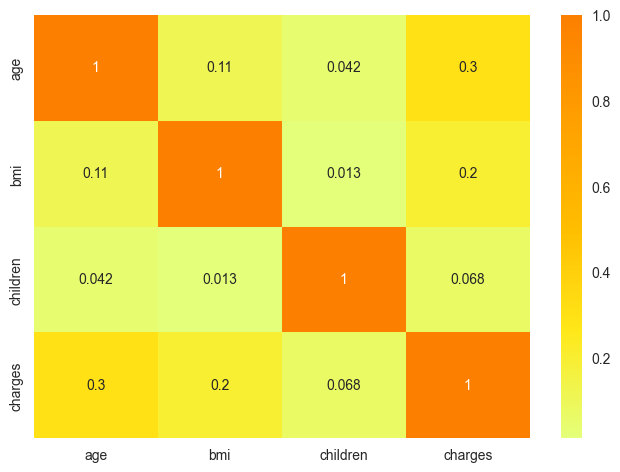

In [6]:
# correlation plot
corr = df.corr() # почитать что делает
sns.heatmap(corr, cmap = 'Wistia', annot= True); #annot= дает числа в квадратах, cmap = стиль карты

Теперь давайте научимся читать эту самую корреляционную матрицу. Обычно все значения на такой матрице принимают значения от -1 до 1, где -1 = обратное (отрицательное) влияние переменной на переменную, +1 = положительное влияние переменной на переменную, 0 = отсутствие корреляции между переменными. Так, к примеру, мы можем по карте выше понять, что на затраты мед страховки *возраст* человека имеет наибольшее влияние, а количество детей у человека имеют самое низкое влияние. Такая карта помогает нам отследить как самые важные параметры среди всех, так и найти зависимости от разных столбцов, потому что если одна независимая переменная будет влиять на другую (а понять это мы сможем по коэффициенту ~1.0), то такие данные будут уже не самыми качественными. <br>
Но не смотря на то, что мы построили тепловую карту, она не полная, потому что, как вы могли заметить, у нас в таблице чуть больше независимых переменных. Да, я говорю про курение, регион проживания, и пол. Они здесь не учитываются, потому что пока еще не совсем понятно, как в численном формате представить все такие данные (на ум приходит только курение как 0 - не курит, и 1 - курит). Да, эта тепловая карта умеет работать только с численными столбцами, но ничего страшного, для других данных существуют другие методы.

---
## Результат
> *Никакой корреляции между переменными*

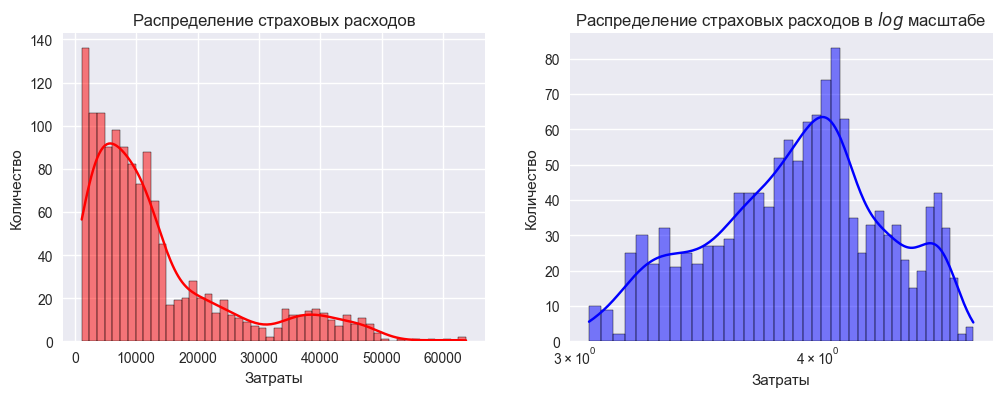

In [7]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121) # добавить
sns.histplot(df['charges'],bins=50,color='r',ax=ax,kde=True) # kde = kernel density estimate, для плавного представления таблицы в виде кривой
ax.set_title('Распределение страховых расходов')
ax.set_xlabel('Затраты')
ax.set_ylabel('Количество')

ax=f.add_subplot(122)
sns.histplot(np.log10(df['charges']),bins=40,color='b',ax=ax,kde=True) # bin = кол-во столбцов на таблице
ax.set_title('Распределение страховых расходов в $log$ масштабе')
ax.set_xlabel('Затраты')
ax.set_ylabel('Количество')
ax.set_xscale('log');

Если вдруг у вас появляются вопросы, что за строки текста, что значат числа (121),(122), то смело нажимайте <a href="https://pyprog.pro/mpl/mpl_main_components.html">*Сюда*</a>, это статья с объяснением многих параметров matplotlib-а. Однако если у вас есть вопросы по библиотеке seaborn, то вот еще <a href="https://seaborn.pydata.org/generated/seaborn.histplot.html">*Ссылка*</a> (не будем же мы с вами сидеть и обсуждать все параметры вдвоем, что-то ты сам сделаешь)

---
## Результат
> Как вы можете заметить, на левом графике значения вальируются в диапазоне от 1121 до 63770, и сам наш график смещен влево, поэтому в дальнейшем мы будем использовавть логарифмический график, потому что здесь сильнее видно нормально распределение

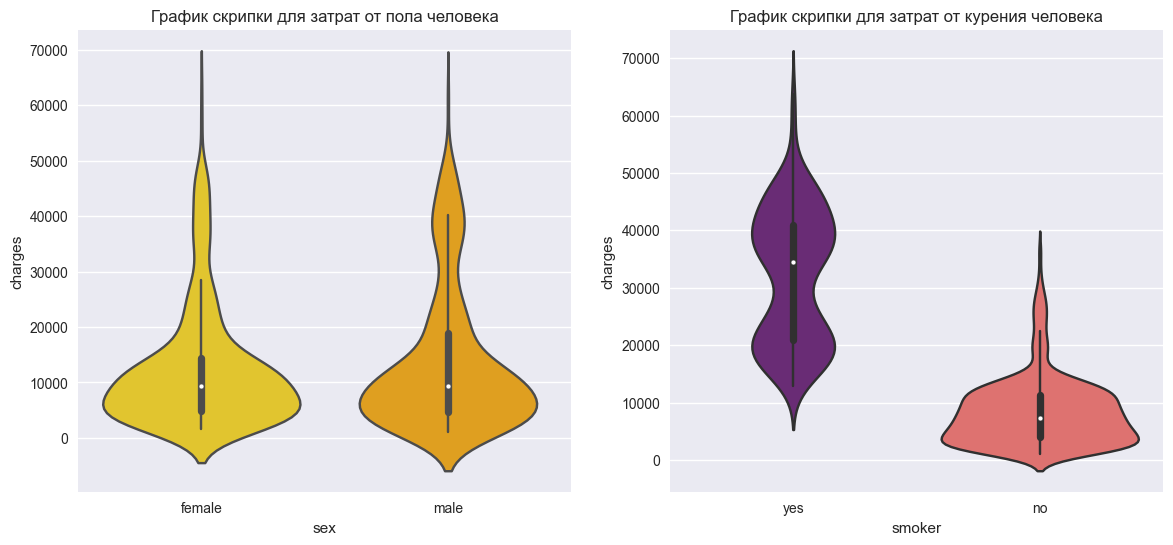

In [8]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121) #ладно, 121 = по оси y график займет всё прост-во, по иксу займет (1/2), и стоять будет в первом разделении (1), т.е. слева
sns.violinplot(x='sex', y='charges',data=df,palette='Wistia',ax=ax)
ax.set_title('График скрипки для затрат от пола человека')

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=df,palette='magma',ax=ax)
ax.set_title('График скрипки для затрат от курения человека');

Да, это называется график скрипки, и он также удобен для просмотра одной зависимости, имеющего разные ответы, к примеру пол - мужской, женский, и тд. То есть нам и не нужны даже числа, всё мы можем сделать и без них. Ссылка на почитать, что это, и как пользоваться, также есть <a href="https://plotly.com/python/violin/">*Здесь*</a>

---
## Результат
> Как видите на левом графике, пол человека почти никак не влияет на количество расходов страховой фирмы. Среднее значение для мужчин и женщин примерно 9000 долларов (Да, я раскрыл вам тайну, дело происходит не в России). У мужчин верхняя точка затрат бывает даже немного выше, да и медианные значения чуть выше чем у женщин, но это всё влияние пары процент, не более.
> А теперь посмотрим на правый график, и... Фух, это, конечно, шокирует! Графики максимально отличаются друг от друга, среднее значение у некурящих прмерно 7000-8000 долларов, когда у курящих эти цифры - минимальное значение среди всех опрошенных. Среднее значение для курящих - 35000 долларов. Вот она - цена нашей жизни! Поэтому лучше вообще не курить, это и дешевле, и лучше для здоровья, а главное, что и природу никак не портим

Ниже пойдет боковая диаграмма, про нее читаем <a href="https://datagy.io/seaborn-boxplot/">*Здесь*</a>

Text(0.5, 1.0, 'Боковая диаграмма затрат от детей')

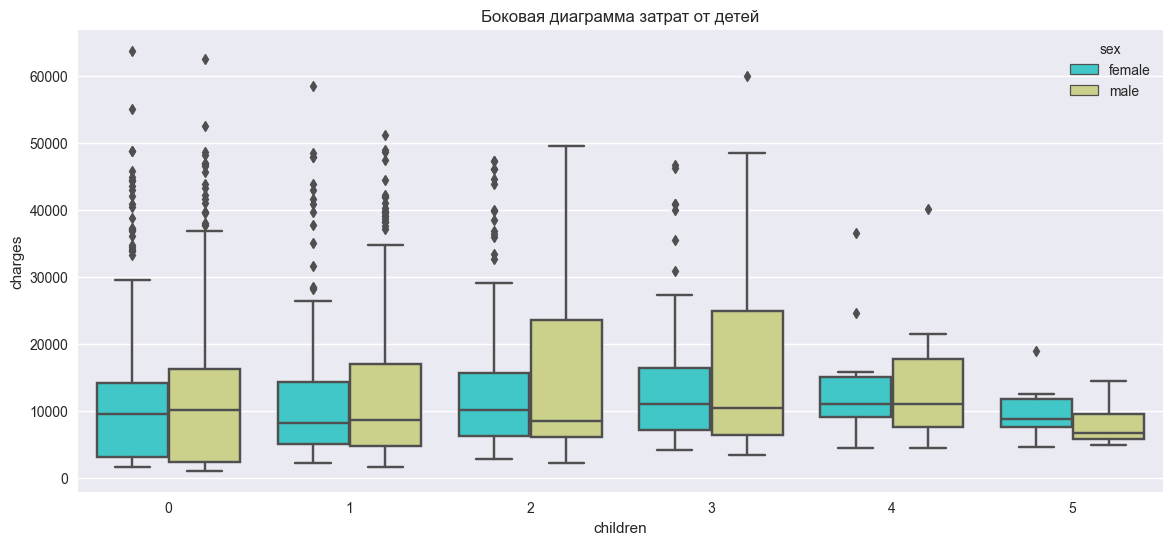

In [9]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children', y='charges', hue='sex', data=df, palette='rainbow') # hue = если поставить smoker, то он будет показывать парные диаграммы для курящи или нет, и тд
plt.title('Боковая диаграмма затрат от детей')

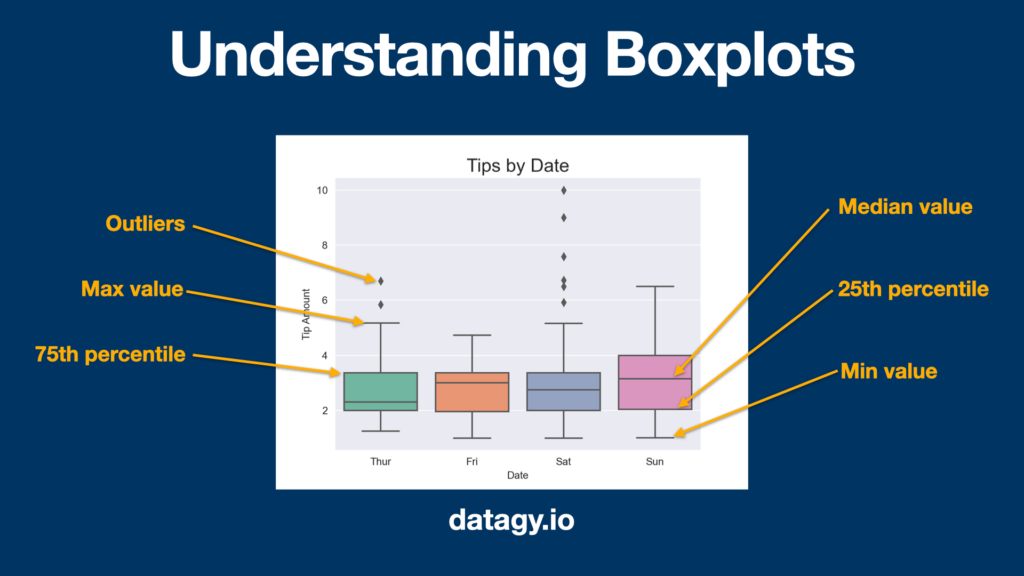

C:\Users\enoki\AppData\Local\Temp\ipykernel_17136\3326673367.py:3: FutureWarning: ['sex', 'smoker', 'region'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('children').agg(['mean','min','max'])['charges'] # пишет предупреждение на будущее, потому что мы не переводим в численные показание слова мужской женский, и тд. (забей)


,mean,min,max
children,,,
0,12365.975602,1121.8739,63770.42801
1,12731.171832,1711.0268,58571.07448
2,15073.563734,2304.0022,49577.66240
3,15355.318367,3443.0640,60021.39897
4,13850.656311,4504.6624,40182.24600
5,8786.035247,4687.7970,19023.26000


In [10]:
from IPython.display import Image # Библиотека для отображения картинок
display(Image(filename='boxplots.png', width = 1000)) # Локальный файл
df.groupby('children').agg(['mean','min','max'])['charges'] # пишет предупреждение на будущее, потому что мы не переводим в численные показание слова мужской женский, и тд. (забей)

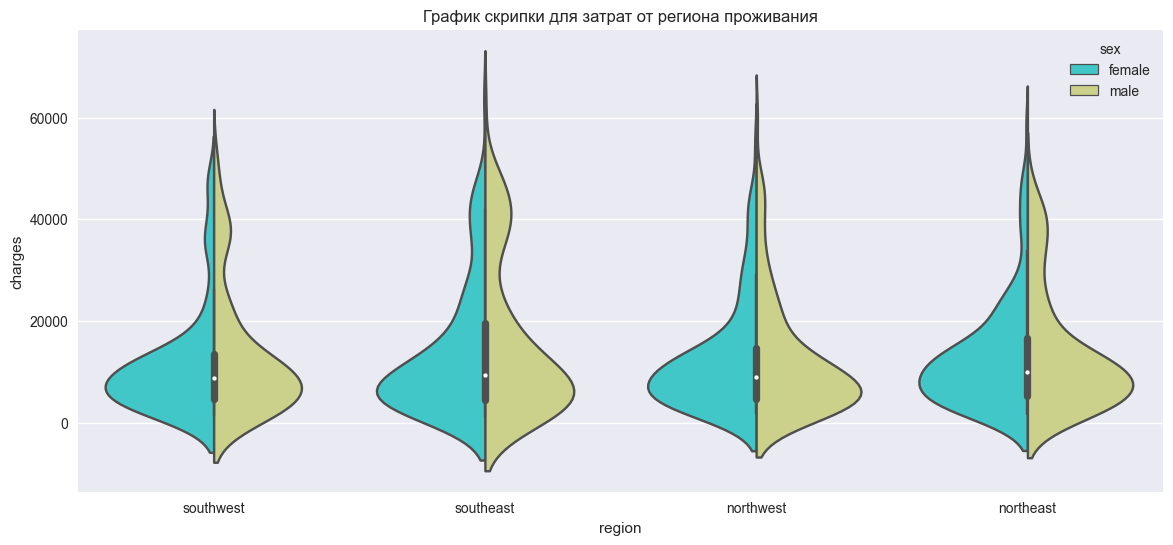

In [11]:

plt.figure(figsize=(14,6))
sns.violinplot(x='region', y='charges',hue='sex',data=df,palette='rainbow',split=True) #split - для половинчатого наложение скрипок друг на друга (в нашей случае оч удобно)
plt.title('График скрипки для затрат от региона проживания');

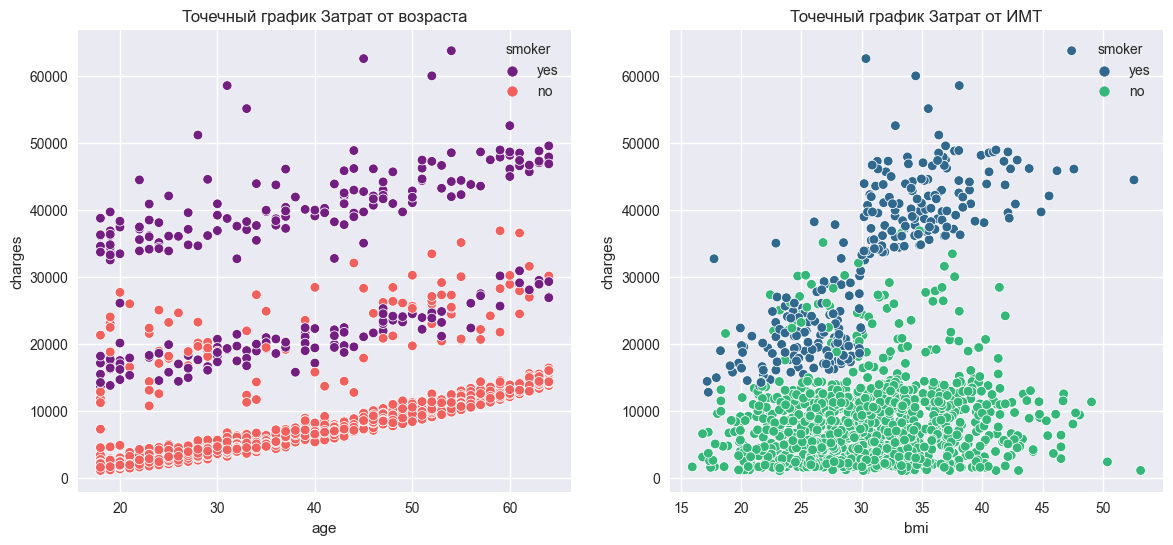

In [12]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df,palette='magma',hue='smoker',ax=ax)
ax.set_title('Точечный график Затрат от возраста')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df,palette='viridis',hue='smoker', ax=ax)
ax.set_title('Точечный график Затрат от ИМТ')
plt.savefig('sc.png');

Как видите, в политике страны, которую мы осматриваем, есть правило застрахованых лиц, что некурящим людям дают первую степень затрат - самую маленькую, когда всем курящим дают вторую и третью степень. То есть на них государство будет тратить больше денег. Также сразу видно, что минимальный возраст опрошанных - 18 лет.

---

## Предварительная обработка данных, кодирование
Как мы с вами ранее уже заметили, алгоритмы машинного обучения плохо работают не с числовыми данными, поэтому слова НЕТ или ДА, как и другие любые слова, должны быть преобразованы в числа.
Существует три различных метода для этого:
1. <a href="https://habr.com/ru/post/666234/">*Кодирование Категориальных Признаков*</a>
2. <a href="https://pythonpip.ru/osnovy/one-hot-encoding-python">*Горячая Кодировка*</a>
3. <a href="https://pythonpip.ru/osnovy/one-hot-encoding-python">*Ловушка Фиктивных Переменных*</a> <br><br>

Кодирование Категориальных Признаков относится к преобразованию словесных меток в числовую форму, чтобы алгоритмы могли понять, как с ними работать. <br><br>
Горячая Кодировка - каждое целочисленное значение представляется в виде двоичного вектора, представляющего собой все нулевые значения, за исключением индекса целого числа, который отмечен знаком 1. Приведем также пример. У нас дома черепаха "Мотя", кошка "Муся", и собака "Мава". Так вот, у Моти тогда будут стоять везде нули напротив слов собака и кошка, но напротив слова черепаха будет стоять 1, и тд. <br><br>
Ловушка Фиктивных Переменных - проще говоря, одна переменная может быть предсказана на основе других. <br><br>
Используя функцию pandas get_dummies, мы можем выполнить все вышеперечисленные три шага в строке кода. Мы используем эту функцию, чтобы получить фиктивную переменную для пола, детей, курильщика, особенностей региона. Установив drop_first =True, функция удалит ловушку фиктивной переменной, отбросив одну переменную и исходную переменную.Pandas облегчают жизнь, и это правда!

In [13]:
categorical_columns = ['sex','children', 'smoker', 'region']
df_encode = pd.get_dummies(data = df, prefix = 'OHE', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
              dtype='int8')
df_encode


,age,bmi,charges,OHE_male,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_yes,OHE_northwest,OHE_southeast,OHE_southwest
0,19,27.900,16884.92400,0,0,0,0,0,0,1,0,0,1
1,18,33.770,1725.55230,1,1,0,0,0,0,0,0,1,0
2,28,33.000,4449.46200,1,0,0,1,0,0,0,0,1,0
3,33,22.705,21984.47061,1,0,0,0,0,0,0,1,0,0
4,32,28.880,3866.85520,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,10600.54830,1,0,0,1,0,0,0,1,0,0
1334,18,31.920,2205.98080,0,0,0,0,0,0,0,0,0,0
1335,18,36.850,1629.83350,0,0,0,0,0,0,0,0,1,0
1336,21,25.800,2007.94500,0,0,0,0,0,0,0,0,0,1


Система работает таким образом: Если в ответах у параметра только 2 разных значения (муж, жен. Или же Да, Нет), то Енкодер шифрует значения двоичным кодом 1 и 0, где 1 = один ответ, 0- оставшийся. Быстро, нужен 1 столбец.
Но если у нас несколько ответов (кол-во детей, например), то создается уже несколько столбцов, и 1 обозначает этот ответ, а 0 ничего не обозначает.
Для того, чтобы обозначить те столбцы, которые мы ходим закодировать (возраст кодировать, к примеру, не нужно), Создается сначала список из названий тех столбов, которые нужны, а потом используем энкодер. Параметр drop_first включается для того, чтобы включить горячую кодировку там, где можно. Можете самостоятельно выключить этот параметр, и вы заметите разницу. Также, после использования метода dummy, часто проверяют количество строк и столбцов, чтобы понимать как таблица изменилась. 

In [14]:
print('Значения таблицы в изначальном датасете:\n',df.columns.values)
print('\nРазмер таблицы в изначальном датасете:',df.shape)
print('\nЗначения таблицы в датасете dummy:\n',df_encode.columns.values)
print('\nРазмер таблицы в измененном датасете:',df_encode.shape)

Значения таблицы в изначальном датасете:
 ['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']

Размер таблицы в изначальном датасете: (1338, 7)

Значения таблицы в датасете dummy:
 ['age' 'bmi' 'charges' 'OHE_male' 'OHE_1' 'OHE_2' 'OHE_3' 'OHE_4' 'OHE_5'
 'OHE_yes' 'OHE_northwest' 'OHE_southeast' 'OHE_southwest']

Размер таблицы в измененном датасете: (1338, 13)


---
## Метод Бокса-Кокса
Немного теории из интернета:
>В реальности часто приходится иметь дело со статистическими данными, которые по тем или иным причинам не проходят <u>тест на нормальность.</u> В этой ситуации есть два выхода: либо обратиться к непараметрическим методам, либо воспользоваться специальными методами, позволяющими преобразовать исходную «ненормальную статистику» в «нормальную». Среди множества таких методов преобразований одним из лучших (при неизвестном типе распределения) считается преобразование Бокса-Кокса.

> <u>Критерии нормальности </u> — это выделенный частный случай критериев согласия. Нормально распределённые величины часто встречаются в прикладных задачах, что обусловлено действием закона больших чисел. Если про выборки заранее известно, что они подчиняются нормальному распределению, то к ним становится возможно применять более мощные параметрические критерии. Проверка нормальность часто выполняется на первом шаге анализа выборки, чтобы решить, использовать далее параметрические методы или непараметрические.

Преобразование Бокса Кокса - это способ преобразования ненормальных зависимых переменных в нормальную форму. Нормальность является важным допущением для многих статистических методов; если ваши данные не являются нормальными, применение Бокс-Кокса означает, что вы можете выполнить большее количество тестов. Все, что нам нужно для выполнения этого преобразования, - это найти значение лямбда и применить правило, показанное ниже, к вашей переменной.
$$\mathbf{ \begin {cases}\frac {y^\lambda - 1}{\lambda},& если \,   y_i\neg=0 \\
 log(y_i) & если \,  \lambda = 0 \end{cases}}$$
 Сложность преобразования Бокса-Кокса заключается в том, чтобы найти значение лямбды, однако на практике уже есть готовый инструмент, а именно функция, которая возвращает преобразованную переменную, лямбда-значение,доверительный интервал. Ниже приведено решение:

In [15]:
from scipy.stats import boxcox
y_bc,lam, ci= boxcox(df_encode['charges'],alpha=0.05)
if np.any(df_encode['charges'] <= 0):
    print("есть такое")
#df['charges'] = y_bc  
# Для нашей модели такое преобразование не является наилучшим, поэтому лучше всё же работать в логарифмах, где всё должно быть ок
print(f"Итого:\n $Лямбда = {lam}\n Ci (пока что не знаю что это) = {ci}\n Затраты после преобразования B-C = {y_bc}")

print(f"Преобразуем в логарифмический масштаб нашу таблицу df_encode \n--------------------------------------\nБыло: \n{df_encode['charges']}")
df_encode['charges'] = np.log(df_encode['charges'])
print(f"--------------------------------------\nСтало: \n{df_encode['charges']}")

Итого:
 $Лямбда = 0.043649053770664956
 Ci (пока что не знаю что это) = (-0.01140290617294196, 0.0988096859767545)
 Затраты после преобразования B-C = [12.12897974  8.80859638 10.14752106 ...  8.72968299  9.01913128
 12.9736611 ]
Преобразуем в логарифмический масштаб нашу таблицу df_encode 
--------------------------------------
Было: 
0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64
--------------------------------------
Стало: 
0        9.734176
1        7.453302
2        8.400538
3        9.998092
4        8.260197
          ...    
1333     9.268661
1334     7.698927
1335     7.396233
1336     7.604867
1337    10.279914
Name: charges, Length: 1338, dtype: float64


Давайте разберем преобразование Бокса-Кокса на примере, взятого с <a href="https://progler.ru/blog/preobrazovanie-boksa-koksa-s-ispolzovaniem-python#:~:text=Пакет%20статистики%20SciPy%20предоставляет%20функцию%2C,соответствия%20ненормального%20распределения%20нормальному%20распределению">*Определенного Сайта* </a>

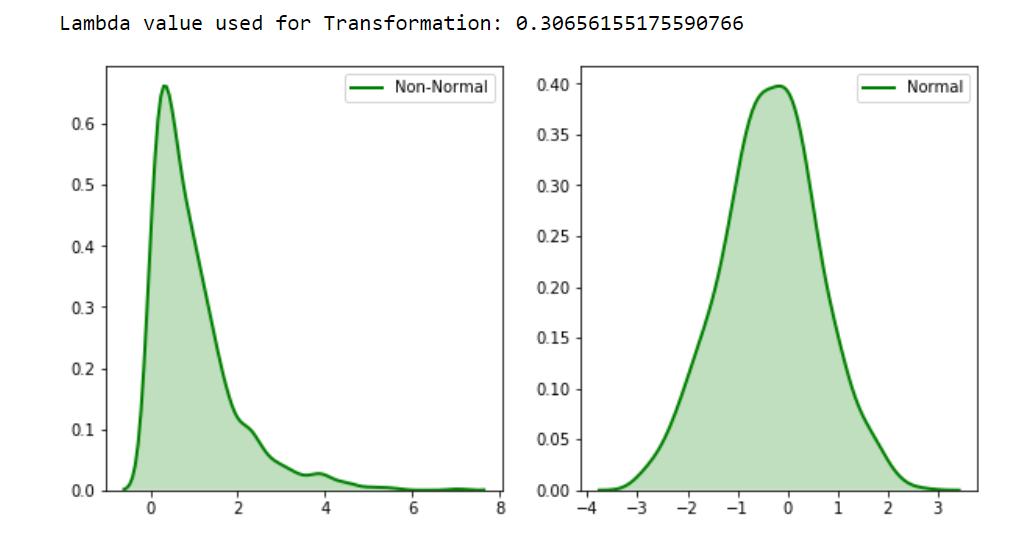

In [16]:
display(Image(filename='boxcox.png', width = 800)) # Локальный файл

## Бокс-кокс всегда работает?
Ответ - **НЕТ** . Box-cox не гарантирует нормальности, потому что он никогда не проверяет нормальность, которая необходима для защиты от дурака, правильно ли он преобразовал ненормальное распределение или нет. Он проверяет только наименьшее стандартное отклонение.

Следовательно, абсолютно необходимо всегда проверять преобразованные данные на нормальность с помощью вероятностного графика.
## Важно
В итоге метод Бокса-Кокса не использовался в дальнейшей обработке, потому что он не сработал как нужно (просто поверьте)

---
## Тестирование
Давайте сначала разделим значения для тестов (хз что это, вот ссылка на почитать)
<a href="https://realpython.com/train-test-split-python-data/"> ТЫК </a>

In [17]:
from sklearn.model_selection import train_test_split
X = df_encode.drop('charges',axis=1) # Убрали зависимую переменную
y = df_encode['charges'] # отдельно запишем зависимую переменную
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

Теперь перейдем к реализации линейной регрессии  $\mathbf{\theta = (X^T X)^{-1} X^Ty}$. Для начала нам нужно добавить в матрицу X столбец с единицами, как было изначально в теории

In [18]:
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train))
theta

array([ 7.05917147,  0.03313425,  0.01351684, -0.06776735,  0.14945669,
        0.27291869,  0.24409489,  0.52333863,  0.46603008,  1.55048077,
       -0.05584487, -0.14657831, -0.13350812])

Всё, мы нашли тетту! дальше нам нужно запихнуть эту тетта в уравнение спрогнозированной функции.  

In [19]:
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])] 
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})
parameter_df

,Parameter,Columns,theta
0,theta_0,intersect:x_0=1,7.059171
1,theta_1,age,0.033134
2,theta_2,bmi,0.013517
3,theta_3,OHE_male,-0.067767
4,theta_4,OHE_1,0.149457
5,theta_5,OHE_2,0.272919
6,theta_6,OHE_3,0.244095
7,theta_7,OHE_4,0.523339
8,theta_8,OHE_5,0.466030
9,theta_9,OHE_yes,1.550481


In [20]:
# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,7.059171,7.059171
1,theta_1,age,0.033134,0.033134
2,theta_2,bmi,0.013517,0.013517
3,theta_3,OHE_male,-0.067767,-0.067767
4,theta_4,OHE_1,0.149457,0.149457
5,theta_5,OHE_2,0.272919,0.272919
6,theta_6,OHE_3,0.244095,0.244095
7,theta_7,OHE_4,0.523339,0.523339
8,theta_8,OHE_5,0.466030,0.466030
9,theta_9,OHE_yes,1.550481,1.550481


Как видите, мы сейчас самостоятельно реализовали подсчет, который выполняет в наше время отдельная функция sk_learn. Такие дела!
Теперь, как раньше говорилось, давайте сравним полученное значение с реальным, и найдем среднеквадратичную ошибку
$$\mathbf{ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}(\hat{y}_i - y_i)^2}$$
Введем также статистическую переменную, которая будет показывать отзывчивость линейной прогрессии. Сейчас объясню. $\mathbf{R^2}$ всегда находится между 0 и 100%, причем чем больше показывает процентов, тем более отзывчивая полученная дата по сравнению с теми данными, которые были изначально. Формула простая:
$$\mathbf{R^2 = 1 - \frac{SSE}{SST}}$$
**SSE = Sum of Square Error**  (Сумма квадратов ошибки) <br>
**SST = Sum of Square Total**  (Сумма квадратов отклонений)
$$\mathbf{SSE = \sum_{i=1}^{m}(\hat{y}_i - y_i)^2}$$
$$\mathbf{SST = \sum_{i=1}^{m}(y_i - \bar{y}_i)^2}$$
Here $\mathbf{\hat{y}}$ это предсказанное значение, а$\mathbf{\bar{y}}$ is mean value of $\mathbf{y}$.

In [21]:
y_pred_norm =  np.matmul(X_test_0,theta)
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('Средний квадрат ошибки(MSE) или J(theta) is: ',J_mse)
print('R в квадрате - переменная теперь имеет вид :',R_square)

Средний квадрат ошибки(MSE) или J(theta) is:  0.1872962232298195
R в квадрате - переменная теперь имеет вид : 0.7795687545055312


Теперь то же самое, но уже через готовые модели, описанные в sklearn:

In [22]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('Средний квадрат ошибки(MSE) или J(theta) is: ',J_mse_sk)
print('R в квадрате - переменная теперь имеет вид :',R_square_sk)

Средний квадрат ошибки(MSE) или J(theta) is:  0.18729622322981898
R в квадрате - переменная теперь имеет вид : 0.7795687545055318


Как не трудно заметить, значение R^2 примерно 78%, значит наши данные вполне себе хорошие, однако их можно улучшить, если перейти в логарифмический масштаб, как мы видели ранее, и уже на их основе строить модель поведения машины
## Проверка модели
Для начала, нам стоит проверить модель с теорией о модели линейной регрессии. Может, эта модель нам вообще не нужна (поздновато спохватились, но ладно).
1. Связь между переменными должна быть именно линейной. Если в реальности это не так, но нам нужна другая модель.
2. График должен быть нормально распределен
3. Среднее значение ошибки должно стремиться к нулю
4. Все переменные должны быть мномомерно нормальными (Предлагают проверять это на Q-Q графике)
5. Линейная регрессия предполагает, что мультиколлинеарность в данных незначительна или вообще отсутствует. Мультиколлинеарность возникает, когда независимые переменные слишком сильно коррелируют друг с другом. Коэффициент инфляции дисперсии VIF* определяет корреляцию между независимыми переменными и силу этой корреляции. $\mathbf{VIF = \frac {1}{1-R^2}}$ , Если VIF >1 и VIF <5, то это критический уровень мультиколлинеарности.
6. Гомоскедастичность: данные гомоскедастичны, что означает, что остатки равны по всей линии регрессии. Мы можем посмотреть на точечную диаграмму остаточного и подогнанного значения. Если это гетероскедастический график, то он демонстрировал бы рисунок в форме воронки.

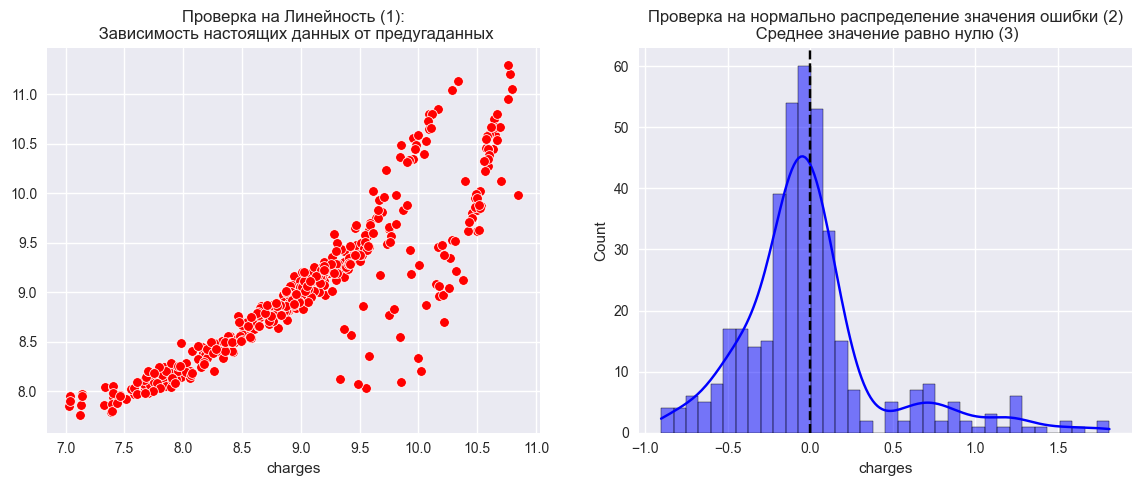

In [40]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x= y_test, y= y_pred_sk, ax=ax,color='r') # 

ax.set_title('Проверка на Линейность (1):\n Зависимость настоящих данных от предугаданных')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.histplot((y_test - y_pred_sk),ax=ax,color='b', kde=True )
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Проверка на нормально распределение значения ошибки (2)\n Среднее значение равно нулю (3)');

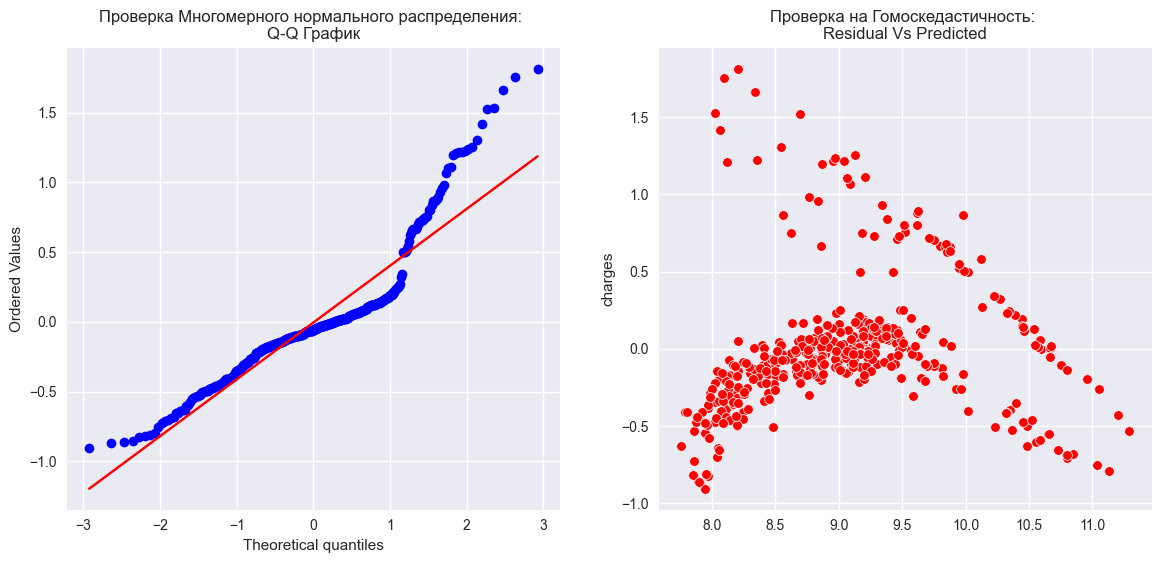

In [48]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_sk),fit=True,plot=ax[0])
ax[0].set_title('Проверка Многомерного нормального распределения: \nQ-Q График')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_sk), x= y_pred_sk, ax = ax[1],color='r') 
ax[1].set_title('Проверка на Гомоскедастичность: \nResidual Vs Predicted');

In [47]:
VIF = 1/(1- R_square_sk)
VIF

4.536561945911135

Итого:
1. В нашей модели фактический и прогнозируемый график являются кривыми, поэтому линейное предположение не выполняется
2. Остаточное среднее значение равно нулю, а график остаточной ошибки искажен вправо
3. Q-Q что-то показывает, я пока не понимаю что
4. График явно гетероскедастический, и ошибка явно будет увеличиваться после определенной точки (не понятно что)
5. Значение коэффициента инфляции дисперсии меньше 5, поэтому мультиколлективности нет.

Комментарии умных людей:
1. Линейная регрессия НЕ требует, чтобы все предикторы были многомерными нормальными. Это никогда не было предположением о линейной регрессии, и я никогда не понимал, почему так много людей так думают.
Тоесть, Q-Q график можно пока и не понимать) потому что речь о нем
2. 
## Конец
К чему же мы с вами пришли? А к тому, блин, что эти данные нам не подходят для использования линейной регрессии по некоторым параметрам, хотя мы можем в некоторой степени оценить затраты страховочной фирмы с помощью этой модели, если значения не будут слишком высокими. Ну тогда покажите, что ваш проект вообще работает! Предугадайте, сколько будет затрат, если ввести какие-нибудь данные, и всё! Сейчас попробуем.

In [58]:
print(f"Таблица для сравнения:\n{parameter_df}\n Таблица с константами тетта:\n{parameter_df['theta']}\n")

Таблица для сравнения:
   Parameter          Columns     theta  Sklearn_theta
0    theta_0  intersect:x_0=1  7.059171       7.059171
1    theta_1              age  0.033134       0.033134
2    theta_2              bmi  0.013517       0.013517
3    theta_3         OHE_male -0.067767      -0.067767
4    theta_4            OHE_1  0.149457       0.149457
5    theta_5            OHE_2  0.272919       0.272919
6    theta_6            OHE_3  0.244095       0.244095
7    theta_7            OHE_4  0.523339       0.523339
8    theta_8            OHE_5  0.466030       0.466030
9    theta_9          OHE_yes  1.550481       1.550481
10  theta_10    OHE_northwest -0.055845      -0.055845
11  theta_11    OHE_southeast -0.146578      -0.146578
12  theta_12    OHE_southwest -0.133508      -0.133508
 Таблица с константами тетта:
0     7.059171
1     0.033134
2     0.013517
3    -0.067767
4     0.149457
5     0.272919
6     0.244095
7     0.523339
8     0.466030
9     1.550481
10   -0.055845
11   -0.1465

Давайте самостоятельно выберем разные константы. Допустим, нам 30 лет, bmi=27.0, у нас двое детей, я мужчина, живу в southwest, и Курю.

In [71]:
X_check=[1, 30, 27.0, 1, 0,1,0,0,0,1,0,0,1]
print(X_check)
Answer=X_check*parameter_df['theta']
print(f"Полученные значения\n{Answer}\nнужно суммировать, тогда получится: {sum(Answer)}\nА если взять обратный логарифм, тогда и получатся наши затраты: {np.e**sum(Answer)}")

[1, 30, 27.0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
Полученные значения
0     7.059171
1     0.994027
2     0.364955
3    -0.067767
4     0.000000
5     0.272919
6     0.000000
7     0.000000
8     0.000000
9     1.550481
10   -0.000000
11   -0.000000
12   -0.133508
Name: theta, dtype: float64
нужно суммировать, тогда получится: 10.04027742015172
А если взять обратный логарифм, тогда и получатся наши затраты: 22931.74376209444


Таким образом, мы получили число, которое высчитала машина!!! Поздравляем, вот ваши 22931$ от страховой фирмы! И ни доллар больше вы от нас не получите!